# Capstone Project 2 - Ron Hankey

## Machine Learning-Based Prediction of Diabetes Using CDC Health Indicators

### Problem statement: Diabetes significantly impacts the health and well-being of millions of people in the United States. It is a leading cause of serious health complications such as heart disease, stroke, kidney failure, blindness, and lower-limb amputations. The prevalence of diabetes leads to substantial medical costs, both direct and indirect, including hospitalizations, medical care, and lost work and wages. People living with diabetes often require lifelong care and management, including regular monitoring of blood sugar levels, adherence to dietary restrictions, and physical activity.

### As the illustration below from the Los Angeles Times shows, one in three adults in the USA could have diabetes by 2050 if current trends continue. So it is vitally important to examine the factors that are contributing to this disease and attempt to mitigate them. 

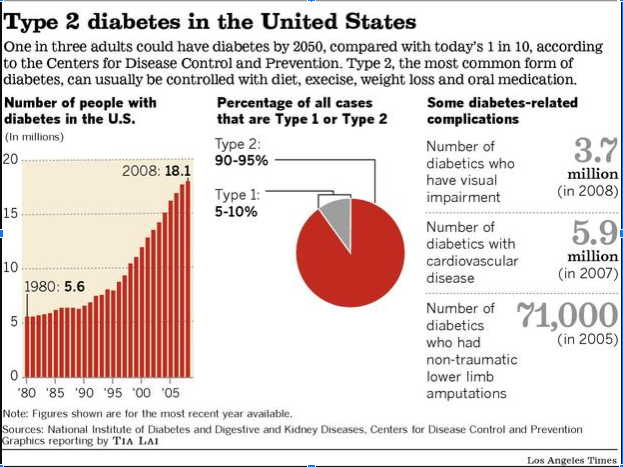

### In addition to the health costs associated with caring for diabetics, some states monitor health statistics regarding diabetes by practice, which can result in fines and legal action if it is determined that the practice population is not being properly managed.   

### The emotional and mental health burden is also notable, as managing diabetes can be stressful and may lead to anxiety and depression. Additionally, certain populations, including older adults, certain racial and ethnic groups, and those with lower socioeconomic status, are disproportionately affected by diabetes, highlighting a need for targeted public health interventions. The epidemic of diabetes underscores the importance of public health efforts focused on prevention, early detection, and effective management to mitigate its impact on individuals and society as a whole.

In [ ]:
# Make sure the requisite library is installed
!pip install ucimlrepo
!pip install xgboost
!pip install lightgbm
!pip install catboost

In [1]:
import time

# Import the pandas, and ucimlrepo libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo 
import scipy.stats as stats

# Import the pipeline and models
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier

# Import model evaluation libraries
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Start Data Wrangling

In [2]:
# Fetch the diabetes dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets

In [3]:
# Load a dataframe with the target variable
target_df = pd.DataFrame(y)

In [4]:
# Check the data was loaded
target_df.head()

,Diabetes_binary
0,0
1,0
2,0
3,0
4,0


In [5]:
# Load a dataframe with the features 
features_df = pd.DataFrame(X)

In [6]:
# Check the data
features_df.head(10)

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,40,1,0,0,0,0,1,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,25,1,0,0,1,0,0,...,0,1,3,0,0,0,0,7,6,1
2,1,1,1,28,0,0,0,0,1,0,...,1,1,5,30,30,1,0,9,4,8
3,1,0,1,27,0,0,0,1,1,1,...,1,0,2,0,0,0,0,11,3,6
4,1,1,1,24,0,0,0,1,1,1,...,1,0,2,3,0,0,0,11,5,4
5,1,1,1,25,1,0,0,1,1,1,...,1,0,2,0,2,0,1,10,6,8
6,1,0,1,30,1,0,0,0,0,0,...,1,0,3,0,14,0,0,9,6,7
7,1,1,1,25,1,0,0,1,0,1,...,1,0,3,0,0,1,0,11,4,4
8,1,1,1,30,1,0,1,0,1,1,...,1,0,5,30,30,1,0,9,5,1
9,0,0,1,24,0,0,0,0,0,1,...,1,0,2,0,0,0,1,8,4,3


In [7]:
# Merge the 2 dataframes into 1
merged_df = target_df.merge(features_df, left_index=True, right_index=True)

In [8]:
# Check the merged data
merged_df.head(10)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4
5,0,1,1,1,25,1,0,0,1,1,...,1,0,2,0,2,0,1,10,6,8
6,0,1,0,1,30,1,0,0,0,0,...,1,0,3,0,14,0,0,9,6,7
7,0,1,1,1,25,1,0,0,1,0,...,1,0,3,0,0,1,0,11,4,4
8,1,1,1,1,30,1,0,1,0,1,...,1,0,5,30,30,1,0,9,5,1
9,0,0,0,1,24,0,0,0,0,0,...,1,0,2,0,0,0,1,8,4,3


In [9]:
# Examine the metadata 
print(cdc_diabetes_health_indicators.metadata) 
  
# Examine the variable information 
print(cdc_diabetes_health_indicators.variables) 

{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

In [10]:
# Access the 'features' part directly
features_data = cdc_diabetes_health_indicators.data

In [11]:
# Import the features (data) into a Pandas dataframe
features_df = pd.DataFrame(features_data.features)

In [12]:
# Examine the data
features_df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,40,1,0,0,0,0,1,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,25,1,0,0,1,0,0,...,0,1,3,0,0,0,0,7,6,1
2,1,1,1,28,0,0,0,0,1,0,...,1,1,5,30,30,1,0,9,4,8
3,1,0,1,27,0,0,0,1,1,1,...,1,0,2,0,0,0,0,11,3,6
4,1,1,1,24,0,0,0,1,1,1,...,1,0,2,3,0,0,0,11,5,4


In [13]:
# Make sure we have the number of rows that are supposed to exist in the data set (253680)
merged_df.shape

(253680, 22)

#### To find the meaning of these features: https://www.icpsr.umich.edu/web/NAHDAP/studies/34085/datasets/0001/variables/GENHLTH?archive=nahdap

In [14]:
# Do some preliminary statistices
merged_df.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.139333,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.346294,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [15]:
# How much memory is the data set consuming
merged_df.size

5580960

In [16]:
# Check for NULL values
merged_df.isnull().sum()

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

In [17]:
# Put the column names in a dataframe for processing
df_cols = merged_df.columns

In [18]:
# Make sure we have an index
type(df_cols)

pandas.core.indexes.base.Index

In [19]:
# Check the unique values of each column and verify they look 
for column_name in merged_df.columns:
    print(f"Unique values: {column_name} for column:", merged_df[column_name].unique())

Unique values: Diabetes_binary for column: [0 1]
Unique values: HighBP for column: [1 0]
Unique values: HighChol for column: [1 0]
Unique values: CholCheck for column: [1 0]
Unique values: BMI for column: [40 25 28 27 24 30 34 26 33 21 23 22 38 32 37 31 29 20 35 45 39 19 47 18
 36 43 55 49 42 17 16 41 44 50 59 48 52 46 54 57 53 14 15 51 58 63 61 56
 74 62 64 66 73 85 60 67 65 70 82 79 92 68 72 88 96 13 81 71 75 12 77 69
 76 87 89 84 95 98 91 86 83 80 90 78]
Unique values: Smoker for column: [1 0]
Unique values: Stroke for column: [0 1]
Unique values: HeartDiseaseorAttack for column: [0 1]
Unique values: PhysActivity for column: [0 1]
Unique values: Fruits for column: [0 1]
Unique values: Veggies for column: [1 0]
Unique values: HvyAlcoholConsump for column: [0 1]
Unique values: AnyHealthcare for column: [1 0]
Unique values: NoDocbcCost for column: [0 1]
Unique values: GenHlth for column: [5 3 2 4 1]
Unique values: MentHlth for column: [18  0 30  3  5 15 10  6 20  2 25  1  4  7  8 21 14

In [20]:
# Save the files so we do not have to import it each time.
file_path = 'D:\Data_Science_Bootcamp_Springboard\Capstone_2\cdc_diabetes_target.csv'
target_df.to_csv(file_path, index=False, sep=',', encoding='utf-8')
file_path = 'D:\Data_Science_Bootcamp_Springboard\Capstone_2\cdc_diabetes_features.csv'
features_df.to_csv(file_path, index=False, sep=',', encoding='utf-8')
file_path = 'D:\Data_Science_Bootcamp_Springboard\Capstone_2\cdc_diabetes_merged.csv'
merged_df.to_csv(file_path, index=False, sep=',', encoding='utf-8')

### We can conclude that the data set matches the UC Irving Machine Learning Repository CDC Duiabetes data set
### The data is complete, there are no missing values and does not require any other wrangling.
### The data set is ready for use in the next phase Exploratory Data Analysis (EDA)

## End of Data Wrangling

## Begin Exploratory Data Analysis (EDA)

<html xmlns:o="urn:schemas-microsoft-com:office:office"
xmlns:x="urn:schemas-microsoft-com:office:excel"
xmlns="http://www.w3.org/TR/REC-html40">

<head>
<meta http-equiv=Content-Type content="text/html; charset=windows-1252">
<meta name=ProgId content=Excel.Sheet>
<meta name=Generator content="Microsoft Excel 15">
<link rel=File-List href="Data_Elements_files/filelist.xml">
<style id="Book1_489_Styles">
<!--table
	{mso-displayed-decimal-separator:"\.";
	mso-displayed-thousand-separator:"\,";}
.xl15489
	{padding-top:1px;
	padding-right:1px;
	padding-left:1px;
	mso-ignore:padding;
	color:black;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:Calibri, sans-serif;
	mso-font-charset:0;
	mso-number-format:General;
	text-align:general;
	vertical-align:bottom;
	mso-background-source:auto;
	mso-pattern:auto;
	white-space:nowrap;}
.xl63489
	{padding-top:1px;
	padding-right:1px;
	padding-left:1px;
	mso-ignore:padding;
	color:#1F2328;
	font-size:12.0pt;
	font-weight:700;
	font-style:normal;
	text-decoration:none;
	font-family:"Segoe UI", sans-serif;
	mso-font-charset:0;
	mso-number-format:General;
	text-align:center;
	vertical-align:middle;
	background:white;
	mso-pattern:black none;
	white-space:normal;}
.xl64489
	{color:#1F2328;
	font-size:12.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:"Segoe UI", sans-serif;
	mso-font-charset:0;
	mso-number-format:General;
	text-align:left;
	vertical-align:middle;
	border:.5pt solid windowtext;
	background:white;
	mso-pattern:black none;
	white-space:normal;
	padding-left:9px;
	mso-char-indent-count:1;}
.xl65489
	{padding-top:1px;
	padding-right:1px;
	padding-left:1px;
	mso-ignore:padding;
	color:black;
	font-size:12.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:"Segoe UI", sans-serif;
	mso-font-charset:0;
	mso-number-format:General;
	text-align:general;
	vertical-align:bottom;
	border:.5pt solid windowtext;
	mso-background-source:auto;
	mso-pattern:auto;
	white-space:nowrap;}
.xl66489
	{padding-top:1px;
	padding-right:1px;
	padding-left:1px;
	mso-ignore:padding;
	color:black;
	font-size:11.0pt;
	font-weight:400;
	font-style:normal;
	text-decoration:none;
	font-family:"Segoe UI", sans-serif;
	mso-font-charset:0;
	mso-number-format:General;
	text-align:general;
	vertical-align:bottom;
	border:.5pt solid windowtext;
	mso-background-source:auto;
	mso-pattern:auto;
	white-space:nowrap;}
.xl67489
	{padding-top:1px;
	padding-right:1px;
	padding-left:1px;
	mso-ignore:padding;
	color:#0070C0;
	font-size:12.0pt;
	font-weight:700;
	font-style:normal;
	text-decoration:none;
	font-family:"Segoe UI", sans-serif;
	mso-font-charset:0;
	mso-number-format:General;
	text-align:center;
	vertical-align:bottom;
	mso-background-source:auto;
	mso-pattern:auto;
	white-space:nowrap;}
-->
</style>
<title>Data Elements</title>
</head>

<body>
<!--[if !excel]>&nbsp;&nbsp;<![endif]-->
<!--The following information was generated by Microsoft Excel's Publish as Web
Page wizard.-->
<!--If the same item is republished from Excel, all information between the DIV
tags will be replaced.-->
<!----------------------------->
<!--START OF OUTPUT FROM EXCEL PUBLISH AS WEB PAGE WIZARD -->
<!----------------------------->

<div id="Book1_489" align=center x:publishsource="Excel">

<h1 style='color:black;font-family:Calibri;font-size:14.0pt;font-weight:800;
font-style:normal'>Data Elements</h1>

<table border=0 cellpadding=0 cellspacing=0 width=762 style='border-collapse:
 collapse;table-layout:fixed;width:572pt'>
 <col width=174 style='mso-width-source:userset;mso-width-alt:6363;width:131pt'>
 <col width=588 style='mso-width-source:userset;mso-width-alt:21504;width:441pt'>
 <tr height=23 style='height:17.25pt'>
  <td height=23 class=xl15489 width=174 style='height:17.25pt;width:131pt'></td>
  <td class=xl67489 width=588 style='width:441pt'>Data Elements</td>
 </tr>
 <tr height=23 style='height:17.25pt'>
  <td height=23 class=xl63489 width=174 style='height:17.25pt;width:131pt'>Feature</td>
  <td class=xl63489 width=588 style='width:441pt'>Description</td>
 </tr>
 <tr height=23 style='height:17.25pt;box-sizing: border-box;background-color:
  var(--bgColor-default, var(--color-canvas-default));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=23 class=xl64489 width=174 style='height:17.25pt;width:131pt;
  box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Diabetes_binary</td>
  <td class=xl64489 width=588 style='border-left:none;width:441pt;box-sizing: border-box;
  border:var(--borderColor-default, var(--color-border-default))'>0 = no
  diabetes 1 = prediabetes/diabetes.</td>
 </tr>
 <tr height=46 style='height:34.5pt;box-sizing: border-box;background-color:
  var(--bgColor-muted, var(--color-canvas-subtle));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=46 class=xl64489 width=174 style='height:34.5pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>High
  blood pressure</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>0
  = no high BP 1 = high BP.</td>
 </tr>
 <tr height=23 style='height:17.25pt;box-sizing: border-box;background-color:
  var(--bgColor-default, var(--color-canvas-default));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=23 class=xl64489 width=174 style='height:17.25pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>high
  cholesterol</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>0
  = no high cholesterol 1 = high cholesterol.</td>
 </tr>
 <tr height=46 style='height:34.5pt;box-sizing: border-box;background-color:
  var(--bgColor-muted, var(--color-canvas-subtle));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=46 class=xl64489 width=174 style='height:34.5pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Cholesterol
  Check</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>0
  = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years.</td>
 </tr>
 <tr height=23 style='height:17.25pt;box-sizing: border-box;background-color:
  var(--bgColor-default, var(--color-canvas-default));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=23 class=xl64489 width=174 style='height:17.25pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>BMI</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Body
  Mass Index.</td>
 </tr>
 <tr height=46 style='height:34.5pt;box-sizing: border-box;background-color:
  var(--bgColor-muted, var(--color-canvas-subtle));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=46 class=xl64489 width=174 style='height:34.5pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Smoker</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Have
  you smoked at least 100 cigarettes in your entire life? 0 = no 1 = yes.</td>
 </tr>
 <tr height=23 style='height:17.25pt;box-sizing: border-box;background-color:
  var(--bgColor-default, var(--color-canvas-default));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=23 class=xl64489 width=174 style='height:17.25pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Stroke</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>(Ever
  told) you had a stroke. 0 = no 1 = yes</td>
 </tr>
 <tr height=46 style='height:34.5pt;box-sizing: border-box;background-color:
  var(--bgColor-muted, var(--color-canvas-subtle));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=46 class=xl64489 width=174 style='height:34.5pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>HeartDiseaseorAttack</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>coronary
  heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes .</td>
 </tr>
 <tr height=46 style='height:34.5pt;box-sizing: border-box;background-color:
  var(--bgColor-default, var(--color-canvas-default));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=46 class=xl64489 width=174 style='height:34.5pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>PhysActivity</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>physical
  activity in past 30 days - not including job 0 = no 1 = yes .</td>
 </tr>
 <tr height=23 style='height:17.25pt;box-sizing: border-box;background-color:
  var(--bgColor-muted, var(--color-canvas-subtle));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=23 class=xl64489 width=174 style='height:17.25pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Fruits</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Consume
  Fruit 1 or more times per day 0 = no 1 = yes .</td>
 </tr>
 <tr height=23 style='height:17.25pt;box-sizing: border-box;background-color:
  var(--bgColor-default, var(--color-canvas-default));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=23 class=xl64489 width=174 style='height:17.25pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Veggies</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Consume
  Vegetables 1 or more times per day 0 = no 1 = yes.</td>
 </tr>
 <tr height=69 style='height:51.75pt;box-sizing: border-box;background-color:
  var(--bgColor-muted, var(--color-canvas-subtle));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=69 class=xl64489 width=174 style='height:51.75pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>HvyAlcoholConsump</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Heavy
  drinkers (adult men having more than 14 drinks per week and adult women
  having more than 7 drinks per week) 0 = no 1 = yes.</td>
 </tr>
 <tr height=46 style='height:34.5pt;box-sizing: border-box;background-color:
  var(--bgColor-default, var(--color-canvas-default));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=46 class=xl64489 width=174 style='height:34.5pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>AnyHealthcare</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Have
  any kind of health care coverage, including health insurance, prepaid plans
  such as HMO, etc. 0 = no 1 = yes.</td>
 </tr>
 <tr height=46 style='height:34.5pt;box-sizing: border-box;background-color:
  var(--bgColor-muted, var(--color-canvas-subtle));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=46 class=xl64489 width=174 style='height:34.5pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>NoDocbcCost</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Was
  there a time in the past 12 months when you needed to see a doctor but could
  not because of cost? 0 = no 1 = yes.</td>
 </tr>
 <tr height=46 style='height:34.5pt;box-sizing: border-box;background-color:
  var(--bgColor-default, var(--color-canvas-default));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=46 class=xl64489 width=174 style='height:34.5pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>GenHlth</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Would
  you say that in general your health is: scale 1-5 1 = excellent 2 = very good
  3 = good 4 = fair 5 = poor.</td>
 </tr>
 <tr height=79 style='mso-height-source:userset;height:59.25pt;box-sizing: border-box;
  background-color:var(--bgColor-muted, var(--color-canvas-subtle));border-top:
  var(--borderColor-muted, var(--color-border-muted))'>
  <td height=79 class=xl64489 width=174 style='height:59.25pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>MentHlth</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt'>Now thinking about your mental health, which includes stress,
  depression, and problems with emotions, for how many days during the past 30
  days was your mental health not good? scale 1-30 days</td>
 </tr>
 <tr height=69 style='height:51.75pt;box-sizing: border-box;background-color:
  var(--bgColor-default, var(--color-canvas-default));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=69 class=xl64489 width=174 style='height:51.75pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>PhysHlth</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Now
  thinking about your physical health , for how many days during the past 30
  days was your physical health not good? scale 1-30 days .</td>
 </tr>
 <tr height=46 style='height:34.5pt;box-sizing: border-box;background-color:
  var(--bgColor-muted, var(--color-canvas-subtle));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=46 class=xl64489 width=174 style='height:34.5pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>DiffWalk</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Do
  you have serious difficulty walking or climbing stairs? 0 = no 1 = yes.</td>
 </tr>
 <tr height=23 style='height:17.25pt;box-sizing: border-box;background-color:
  var(--bgColor-default, var(--color-canvas-default));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=23 class=xl64489 width=174 style='height:17.25pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Sex</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>0
  = female 1 = male</td>
 </tr>
 <tr height=115 style='height:86.25pt;box-sizing: border-box;background-color:
  var(--bgColor-muted, var(--color-canvas-subtle));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=115 class=xl64489 width=174 style='height:86.25pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Age</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>1
  - Age 18 to 24 / 2 - Age 25 to 29 / 3 - Age 30 to 34<br>
    4 - Age 35 to 39 / 5 - Age 40 to 44 / 6 - Age 45 to 49<br>
    7 - Age 50 to 54 / 8 - Age 55 to 59 / 9 - Age 60 to 64<br>
    10 - Age 65 to 69 / 11 - Age 70 to 74 / 12 - Age 75 to 70<br>
    13 - Age 80 or older</td>
 </tr>
 <tr height=115 style='height:86.25pt;box-sizing: border-box;background-color:
  var(--bgColor-muted, var(--color-canvas-subtle));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=115 class=xl64489 width=174 style='height:86.25pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Education</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Education
  level (EDUCA see codebook) scale 1-6 1 = Never attended school or only
  kindergarten , 2 = Grades 1 through 8 (Elementary) ,3 = Grades 9 throug 11
  (Some high school), 4 = Grade 12 or GED (High school graduate) , 5 = College
  1 year to 3 years (Some college or technical school) , 6 = College 4 years or
  more (College graduate).</td>
 </tr>
 <tr height=46 style='height:34.5pt;box-sizing: border-box;background-color:
  var(--bgColor-default, var(--color-canvas-default));border-top:var(--borderColor-muted, var(--color-border-muted))'>
  <td height=46 class=xl64489 width=174 style='height:34.5pt;border-top:none;
  width:131pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Income</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt;box-sizing: border-box;border:var(--borderColor-default, var(--color-border-default))'>Income
  scale, scale 1-8 1 = less than $10,000 5 = less than $35,000 8 = $75,000 or
  more.</td>
 </tr>
 <tr height=23 style='height:17.25pt'>
  <td height=23 class=xl65489 style='height:17.25pt;border-top:none'>mrna_booster</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt'>One or more Covid MRNA boosters</td>
 </tr>
 <tr height=23 style='height:17.25pt'>
  <td height=23 class=xl66489 style='height:17.25pt;border-top:none'>prior_covid</td>
  <td class=xl64489 width=588 style='border-top:none;border-left:none;
  width:441pt'>Prior COVID infection verified via test</td>
 </tr>
 <![if supportMisalignedColumns]>
 <tr height=0 style='display:none'>
  <td width=174 style='width:131pt'></td>
  <td width=588 style='width:441pt'></td>
 </tr>
 <![endif]>
</table>

</div>


<!----------------------------->
<!--END OF OUTPUT FROM EXCEL PUBLISH AS WEB PAGE WIZARD-->
<!----------------------------->
</body>

</html>

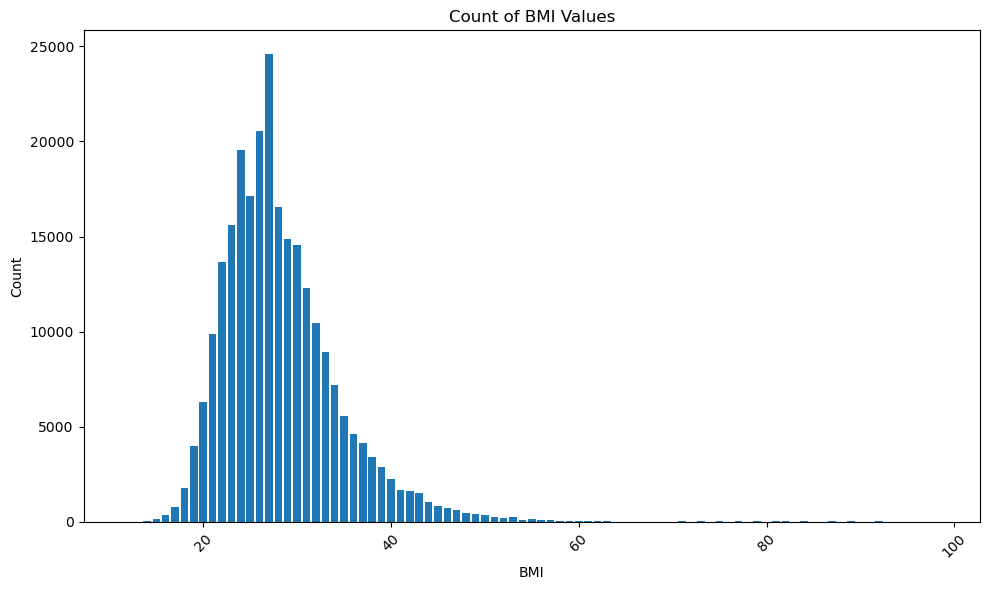

In [21]:
# Let's plot the BMI and see how it is distributed by value
# Count the occurrences of each unique value in the "BMI" column
bmi_counts = features_df['BMI'].value_counts()

# Create the bar chart
# Set the figure size
plt.figure(figsize=(10, 6))  

# Plot the bar chart using plt.bar()
plt.bar(bmi_counts.index, bmi_counts.values)

# Always add labels and titles
plt.xlabel('BMI')
plt.ylabel('Count')
plt.title('Count of BMI Values')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Ensure all elements fit within the figure
plt.tight_layout()  
# Show the plot
plt.show()

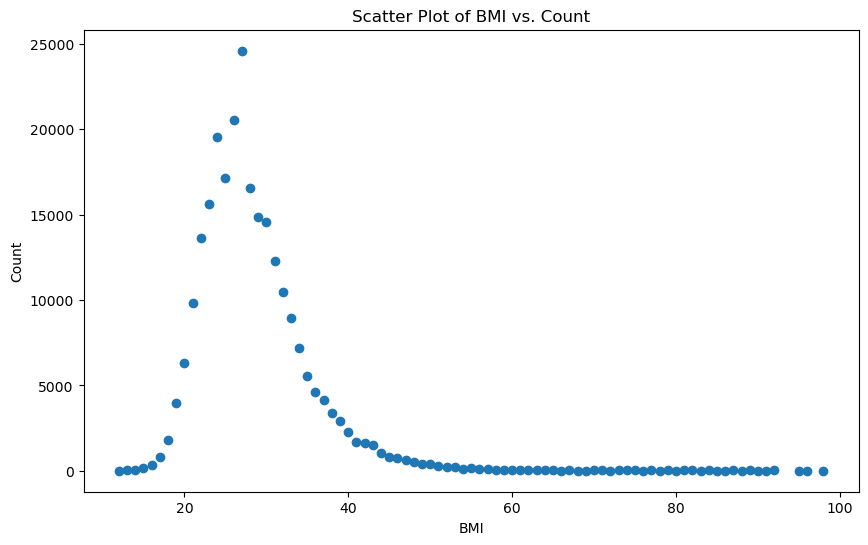

In [22]:
# Since the BMI is so right skewed, some values are barely visible on the bar chart, let's plot a scatter plot instead. 
# Set the figure size
plt.figure(figsize=(10, 6))  
bmi_counts = features_df['BMI'].value_counts().reset_index()
bmi_counts.columns = ['BMI', 'Count']

# Create the scatter plot
plt.scatter(bmi_counts['BMI'], bmi_counts['Count'])

# Set axes labels
plt.xlabel('BMI')
plt.ylabel('Count')

# Title the graph
plt.title('Scatter Plot of BMI vs. Count')

# Show the plot
plt.show()

GENHLTH: GENERAL HEALTH
Question: Prologue: Description: Would you say that in general your health is:

Value	Label	 
    1	Excellent
    2	Very good
    3	Good
    4	Fair
    5	Poor

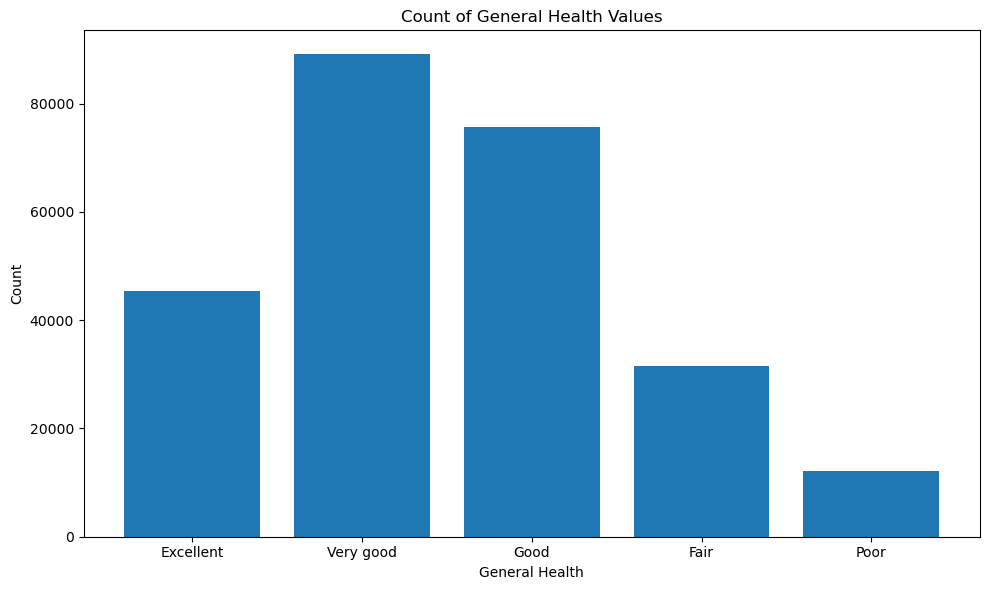

In [23]:
# Let's plot the General Health and see how it is distributed by value
# Create the bar chart

# Set the figure size
plt.figure(figsize=(10, 6))  

# Define the custom labels for the X-axis values
x_labels = {1: 'Excellent', 2: 'Very good', 3: 'Good', 4: 'Fair', 5: 'Poor'}

# Count the occurrences of each value in 'GenHlth'
gh_counts = features_df['GenHlth'].value_counts().sort_index()

# Create the bar chart
plt.bar(x_labels.values(), gh_counts)

# Always add labels and titles
plt.xlabel('General Health')
plt.ylabel('Count')
plt.title('Count of General Health Values')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

# Ensure all elements fit within the figure
plt.tight_layout()  
# Show the plot
plt.show()

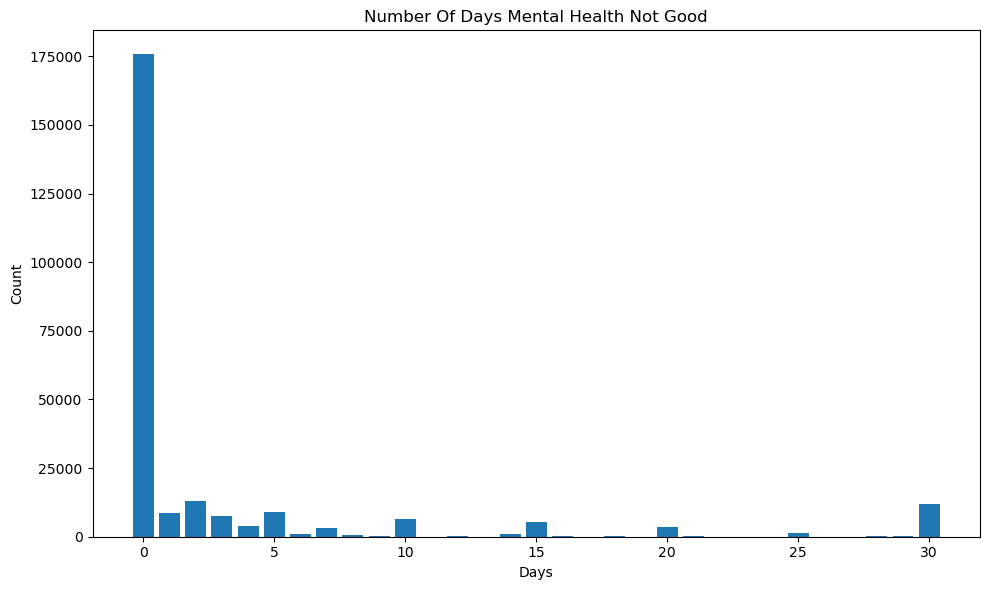

In [24]:
# Let's plot the Mental Health and see how it is distributed by value
# Count the occurrences of each unique value in the "MentHlth" column
mh_counts = features_df['MentHlth'].value_counts()

# Create the bar chart
# Set the figure size
plt.figure(figsize=(10, 6))  

# Plot the bar chart using plt.bar()
plt.bar(mh_counts.index, mh_counts.values)

# Always add labels and titles
plt.xlabel('Days')
plt.ylabel('Count')
plt.title('Number Of Days Mental Health Not Good')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

# Ensure all elements fit within the figure
plt.tight_layout()  
# Show the plot
plt.show()

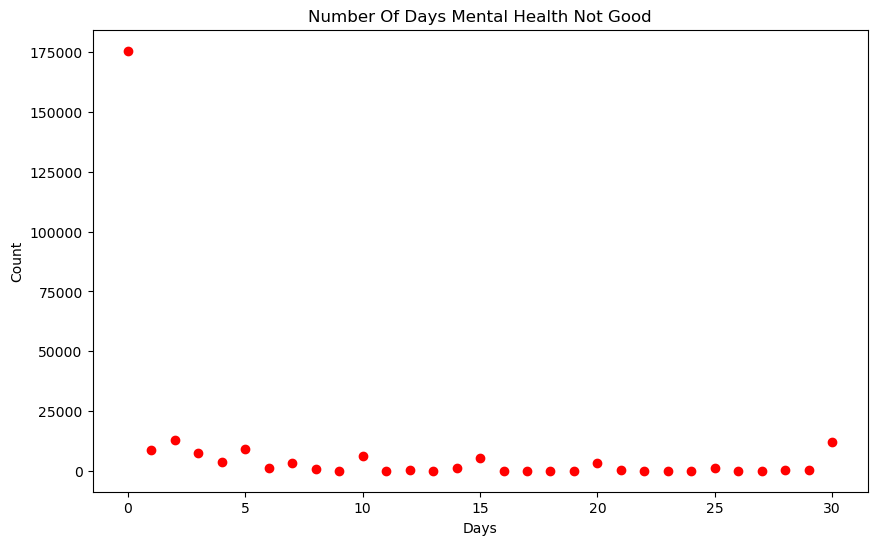

In [25]:
# Since the Mental Health is so right skewed, some values are barely visible on the bar chart, let's plot a scatter plot instead. 
# Set the figure size
plt.figure(figsize=(10, 6))  
mh_counts = features_df['MentHlth'].value_counts().reset_index()
mh_counts.columns = ['MentHlth', 'Count']

# Create the scatter plot
plt.scatter(mh_counts['MentHlth'], mh_counts['Count'], color='red')

# Set axes labels
plt.xlabel('Days')
plt.ylabel('Count')

# Title the graph
plt.title('Number Of Days Mental Health Not Good')

# Show the plot
plt.show()

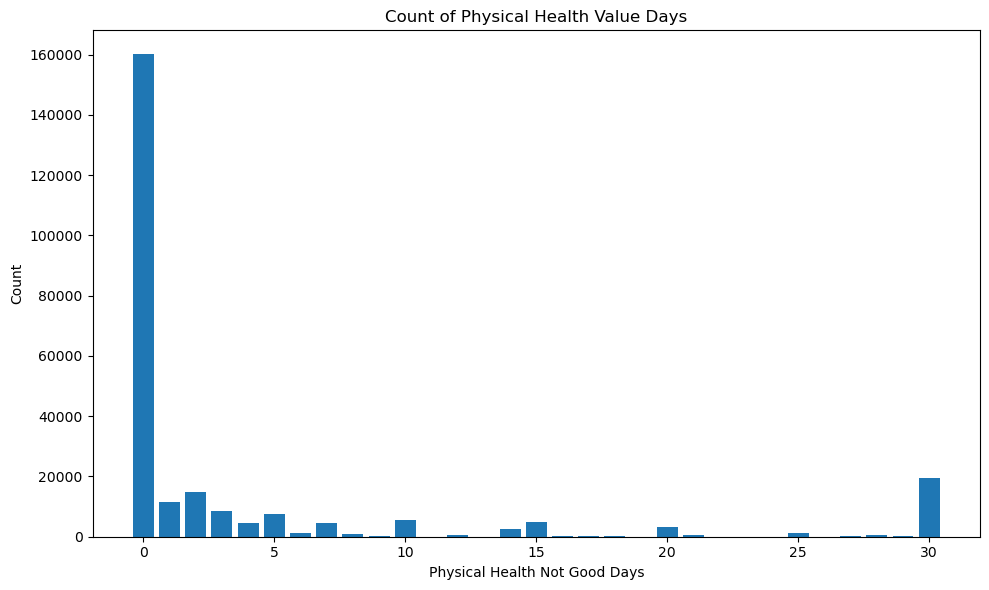

In [26]:
# Let's plot the Physical Health and see how it is distributed by value
# Count the occurrences of each unique value in the "PhysHlth" column
ph_counts = features_df['PhysHlth'].value_counts()

# Create the bar chart
# Set the figure size
plt.figure(figsize=(10, 6))  

# Plot the bar chart using plt.bar()
plt.bar(ph_counts.index, ph_counts.values)

# Always add labels and titles
plt.xlabel('Physical Health Not Good Days')
plt.ylabel('Count')
plt.title('Count of Physical Health Value Days')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

# Ensure all elements fit within the figure
plt.tight_layout()  
# Show the plot
plt.show()

Sex Column
Value    Label
  1      Male
  0      Female

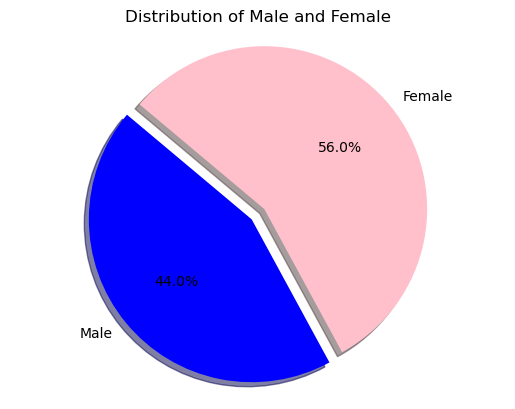

In [27]:
male_count = (features_df['Sex'] == 1).sum()
female_count = (features_df['Sex'] == 0).sum()

# Create a pie chart
labels = ['Male', 'Female']
sizes = [male_count, female_count]
colors = ['blue', 'pink'] 
explode = (0.1, 0) 

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal') 

# Add a title
plt.title('Distribution of Male and Female')

# Show the pie chart
plt.show()

The age data is binned as follows: 
1 Age 18 to 24
2 Age 25 to 29
3 Age 30 to 34
4 Age 35 to 39
5 Age 40 to 44
6 Age 45 to 49
7 Age 50 to 54
8 Age 55 to 59
9 Age 60 to 64
10 Age 65 to 69
11 Age 70 to 74
12 Age 75 to 79
13 Age 80 or older

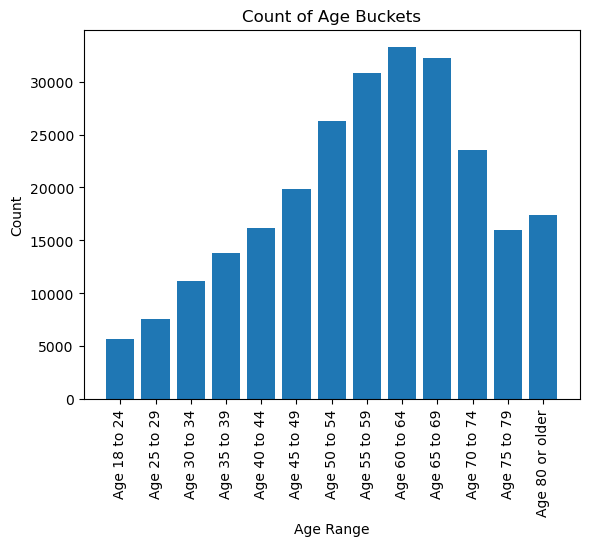

In [28]:
# Define the age buckets
custom_labels = {
    1: 'Age 18 to 24',
    2: 'Age 25 to 29',
    3: 'Age 30 to 34',
    4: 'Age 35 to 39',
    5: 'Age 40 to 44',
    6: 'Age 45 to 49',
    7: 'Age 50 to 54',
    8: 'Age 55 to 59',
    9: 'Age 60 to 64',
    10: 'Age 65 to 69',
    11: 'Age 70 to 74',
    12: 'Age 75 to 79',
    13: 'Age 80 or older'
}

# Count the occurrences of each age value
counts = features_df['Age'].value_counts().sort_index()

# Create the bar chart
plt.bar(custom_labels.values(), counts)

# Set labels for X and Y axes
plt.xlabel('Age Range')
plt.ylabel('Count')

# Set custom X-axis tick labels and rotate them 90 degrees
plt.xticks(rotation=90)

# Set a title
plt.title('Count of Age Buckets')

# Show graph
plt.show()

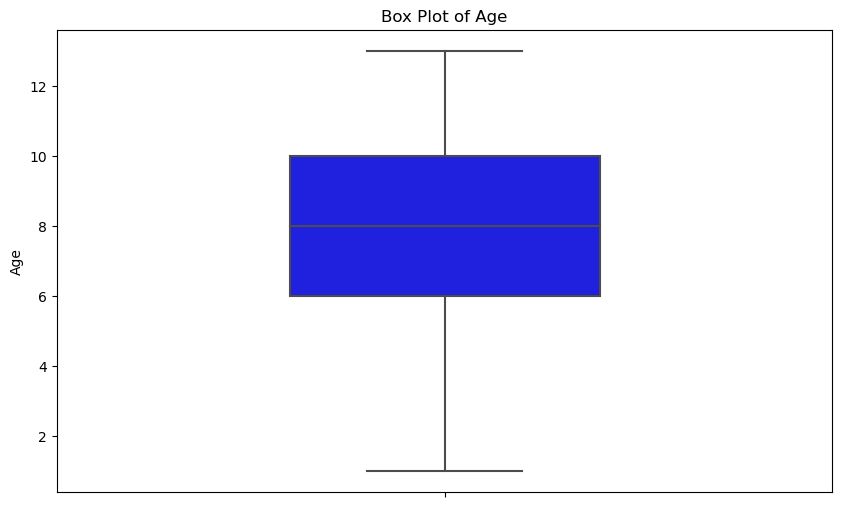

In [29]:
# Create a boxplot for the 'Age' column
plt.figure(figsize=(10, 6))  
sns.boxplot(y='Age', data=merged_df, color='blue', width=0.4)

# Add labels and title
plt.ylabel('Age')
plt.title('Box Plot of Age')

# Show the plot
plt.show()

In [ ]:
## Do NOT run at this time
# Create a swarm plot for the 'Age' column
plt.figure(figsize=(8, 6))  
sns.swarmplot(y='Age', data=merged_df, color='green')

# Add labels and title
plt.ylabel('Age')
plt.title('Swarm Plot of Age')

# Show the plot
plt.show()

What is the highest grade or year of school you completed? = Education

1 Never attended school or only kindergarten
2 Grades 1 through 8 (Elementary)
3 Grades 9 through 11 (Some high school)
4 Grade 12 or GED (High school graduate)
5 College 1 year to 3 years (Some college or technical school)
6 College 4 years or more (College graduate)
9 Refused (All these records were deleted from the dataset)

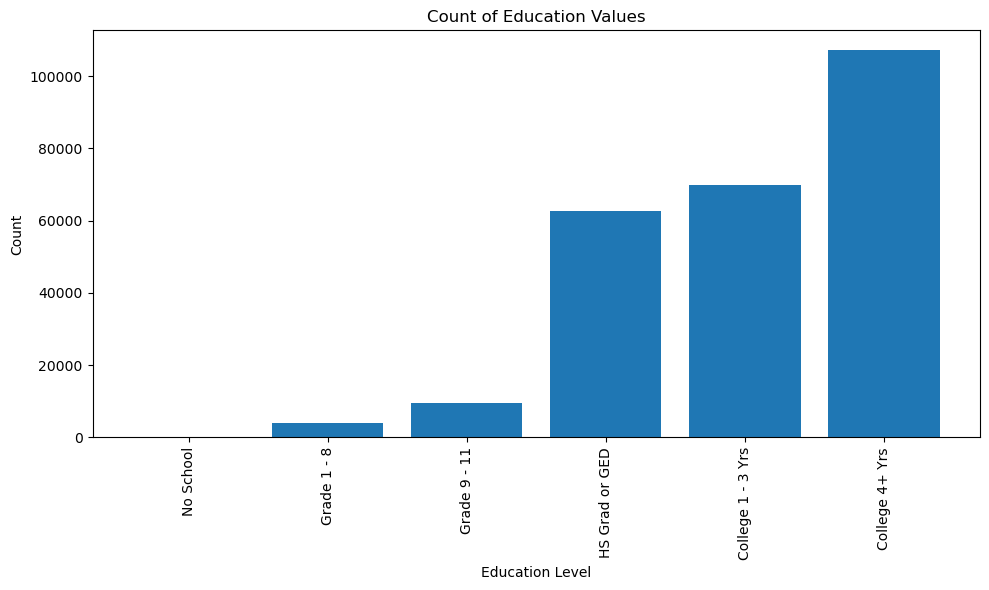

In [30]:
# Let's plot the Education count and see how it is distributed in this data set

custom_labels = {
    1: 'No School',
    2: 'Grade 1 - 8',
    3: 'Grade 9 - 11',
    4: 'HS Grad or GED',
    5: 'College 1 - 3 Yrs',
    6: 'College 4+ Yrs'
}

# Count the occurrences of each unique value in the "Education" column
educ_counts = features_df['Education'].value_counts().sort_index()

# Create the bar chart
# Set the figure size
plt.figure(figsize=(10, 6))  

# Plot the bar chart using plt.bar()
# plt.bar(educ_counts.index, educ_counts.values)
plt.bar(custom_labels.values(), educ_counts)

# Always add labels and titles
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.title('Count of Education Values')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Ensure all elements fit within the figure
plt.tight_layout()  
# Show the plot
plt.show()

Income scale 1-8 1 = less than $10,000 5 = less than $35,000 8 = $75,000 or more

1 Less than $10,000
2 Less than $15,000 ($10,000 to less than $15,000)
3 Less than $20,000 ($15,000 to less than $20,000)
4 Less than $25,000 ($20,000 to less than $25,000)
5 Less than $35,000 ($25,000 to less than $35,000)
6 Less than $50,000 ($35,000 to less than $50,000)
7 Less than $75,000 ($50,000 to less than $75,000)
8 $75,000 or more

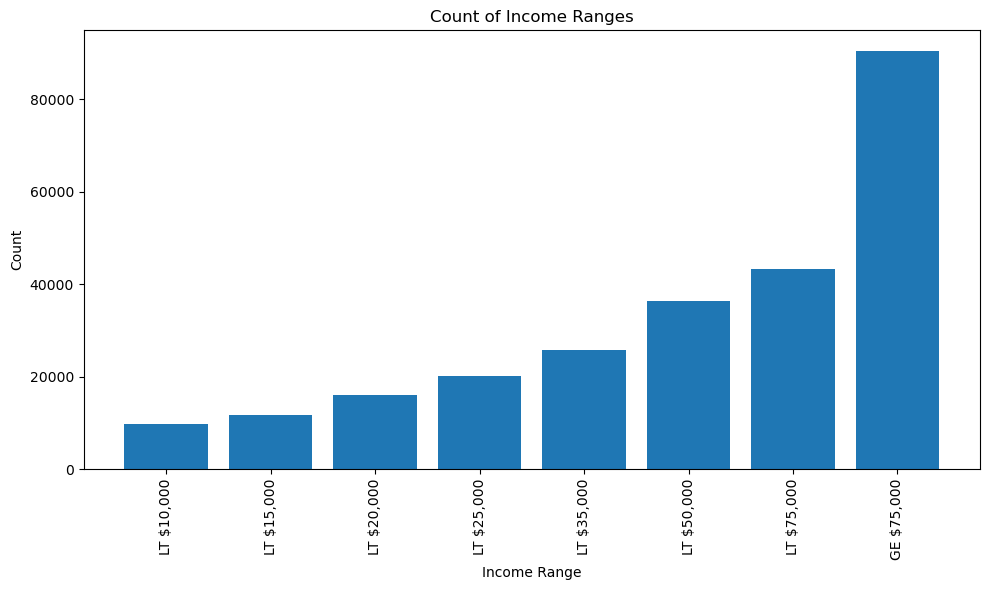

In [33]:
# Let's plot the Income count and see how it is distributed in this data set

custom_labels = {
    1: 'LT $10,000',
    2: 'LT $15,000',
    3: 'LT $20,000',
    4: 'LT $25,000',
    5: 'LT $35,000',
    6: 'LT $50,000',
    7: 'LT $75,000',
    8: 'GE $75,000'
}

# Count the occurrences of each unique value in the "Income" column
inc_counts = features_df['Income'].value_counts().sort_index()

# Create the bar chart
# Set the figure size
plt.figure(figsize=(10, 6))  

# Plot the bar chart using plt.bar()
#plt.bar(bmi_counts.index, inc_counts.values)
plt.bar(custom_labels.values(), inc_counts.values)

# Always add labels and titles
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.title('Count of Income Ranges')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Ensure all elements fit within the figure
plt.tight_layout()  
# Show the plot
plt.show()

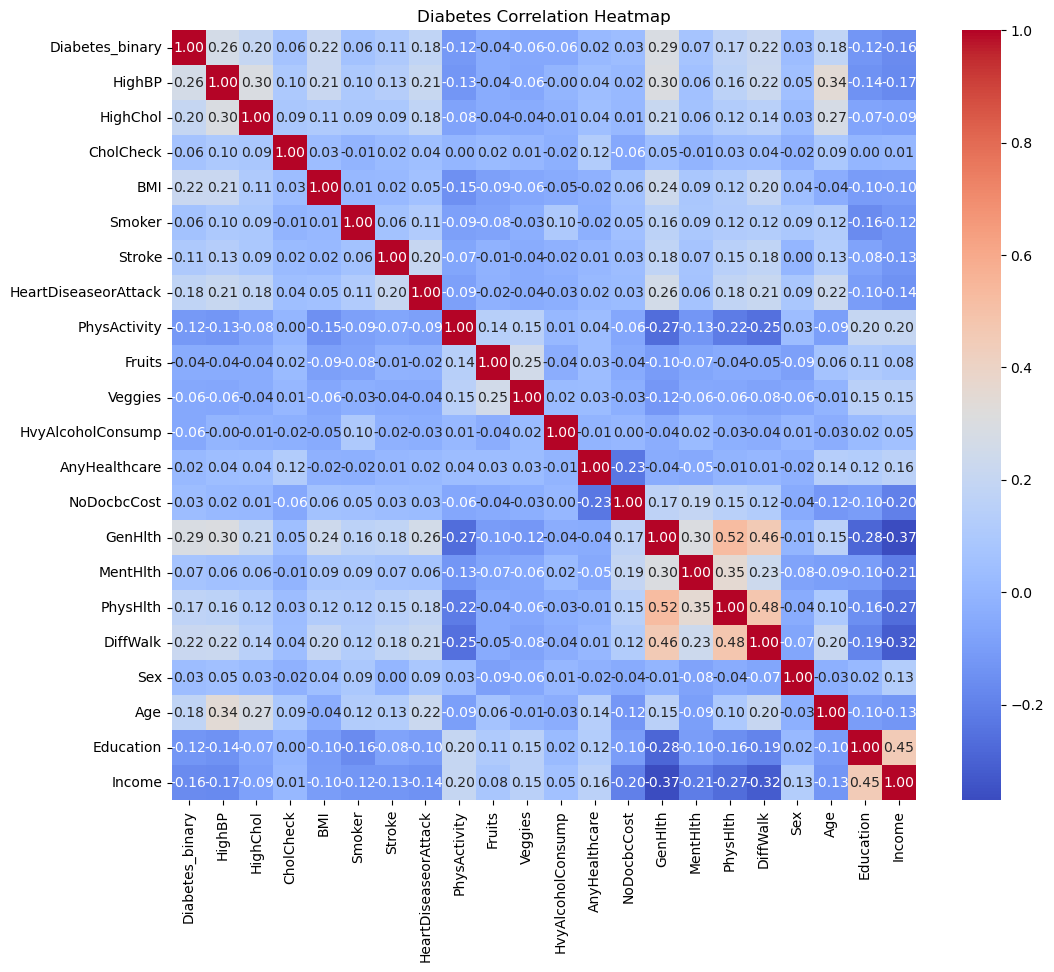

In [34]:
# Calculate the correlation matrix
correlation_matrix = merged_df.corr()

# Set up the Seaborn heatmap
plt.figure(figsize=(12, 10)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Add a title
plt.title("Diabetes Correlation Heatmap")

# Show the plot
plt.show()

In [35]:
# Calculate the Pearson correlation coefficients for 'Diabetes_binary' with other features
correlation_with_target = merged_df.corr(method='pearson')['Diabetes_binary'].drop('Diabetes_binary')

In [36]:
print("The Pearson correlation coefficients for the target variable: Diabetes_binary\n", correlation_with_target)

The Pearson correlation coefficients for the target variable: Diabetes_binary
 HighBP                  0.263129
HighChol                0.200276
CholCheck               0.064761
BMI                     0.216843
Smoker                  0.060789
Stroke                  0.105816
HeartDiseaseorAttack    0.177282
PhysActivity           -0.118133
Fruits                 -0.040779
Veggies                -0.056584
HvyAlcoholConsump      -0.057056
AnyHealthcare           0.016255
NoDocbcCost             0.031433
GenHlth                 0.293569
MentHlth                0.069315
PhysHlth                0.171337
DiffWalk                0.218344
Sex                     0.031430
Age                     0.177442
Education              -0.124456
Income                 -0.163919
Name: Diabetes_binary, dtype: float64


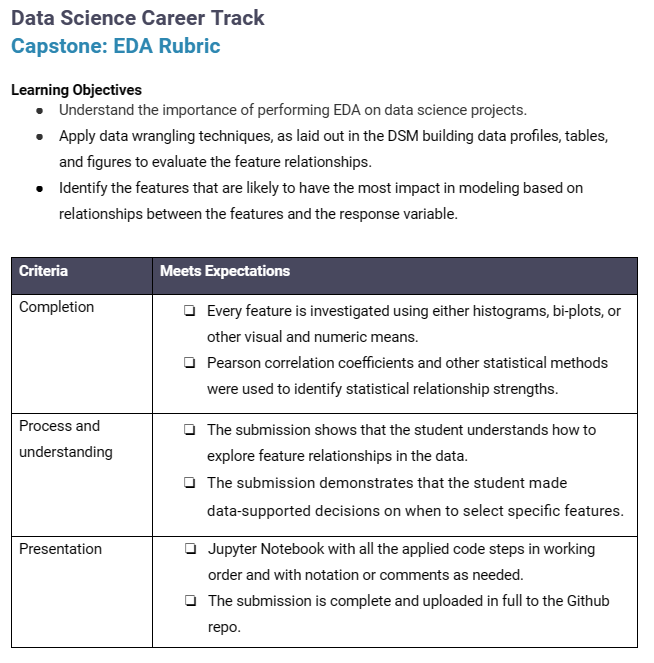

## End Exploratory Data Analysis (EDA)
**<font color='teal'> End Exploratory Data Analysis (EDA) </font>**

 ## Begin Pre-processing & Training Data Development
**<font color='teal'> Begin Pre-processing & Training Data Development </font>**

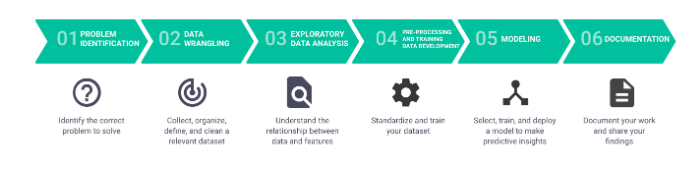

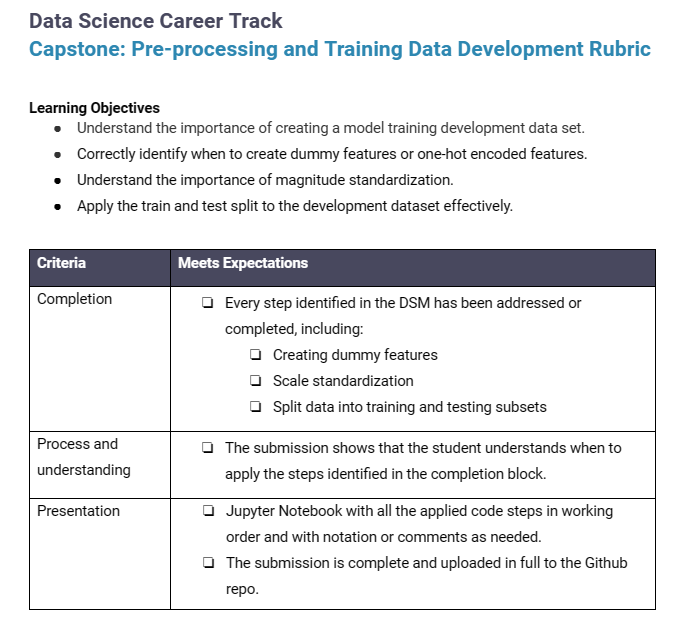

In [37]:
# Create random data for mrna_booster and prior_covid
np.random.seed(47)  # Set a seed for reproducibility

# Generate random values for mrna_booster (17% TRUE, 83% FALSE)
merged_df['mrna_booster'] = np.random.choice([1, 0], size=len(merged_df), p=[0.17, 0.83])

# Generate random values for prior_covid (71% TRUE, 29% FALSE)
merged_df['prior_covid'] = np.random.choice([1, 0], size=len(merged_df), p=[0.71, 0.29])

# Verify the result
print(merged_df[['Diabetes_binary', 'prior_covid', 'mrna_booster']].head())

   Diabetes_binary  prior_covid  mrna_booster
0                0            1             1
1                0            1             0
2                0            1             0
3                0            1             1
4                0            1             1


In [10]:
from sklearn.model_selection import train_test_split
# Define the target variable and features
X = merged_df.drop("Diabetes_binary", axis=1)  # Features - all columns except Diabetes_binary
y = merged_df["Diabetes_binary"]  # Diabetes_binary is the target variable

# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

 ## End Pre-processing & Training Data Development

In [ ]:
## Begin Modeling
**<font color='teal'> Begin Modeling </font>**

**<font color='teal' size='4'>
Data Science Career Track
Capstone Two: Modeling
Overview 
The goal of the modeling step is to develop a final model that effectively predicts the 
stated goal in the problem identification section. Review the types of models that would 
be appropriate given your modeling response and the features in your dataset and build 
two to three models. In addition to considering different algorithm types in your model 
selection, also consider applying model hyperparameter tuning operations. Be sure to 
define the metrics you use to choose your final model. 
If you need a refresher about how to go about building a model, review the work you did 
during the guided capstone and the unit about modeling. 
Project Steps 
Time Estimation: 10-15 Hours 
Modeling 
Goal: Build two to three different models and identify the best one. 
● Fit your models with a training dataset 
Hint: Try a number of different models: you will want to compare their outputs in the 
model evaluation stage. For example, if you’re writing a classification model, you should 
implement both an entropy model and a Gini impurity model. For hyperparameter tuning, 
think of methods like cross-validation . 
● Review model outcomes — Iterate over additional models as needed 
Hint: you may want to use standard model evaluation metrics such as accuracy, recall, 
precision, and F1. 
● Identify the final model that you think is the best model for this project 
Hint: the most powerful model isn’t always the best one to use. Other considerations 
include computational complexity, scalability, and maintenance costs. 
Review the following questions and apply them to your analysis: 
● Does my data involve a time series or forecasting? If so, am I splitting the train 
and test data appropriately? 
● Is my response variable continuous or categorical? 
</font>**
https://ddf46429.springboard.com/uploads/resources/1585590199_Capstone_Two_Step_5__Modeling_-_Google_Docs.pdf

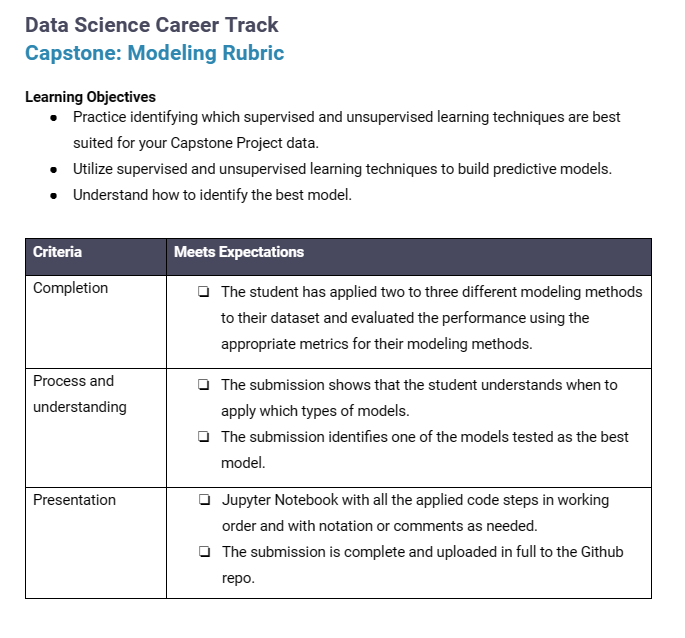

https://docs.google.com/document/d/1rbG66SRqRj73Y-KtI_0qlkMX2CSGrvWddvi1V-WYXcY/edit

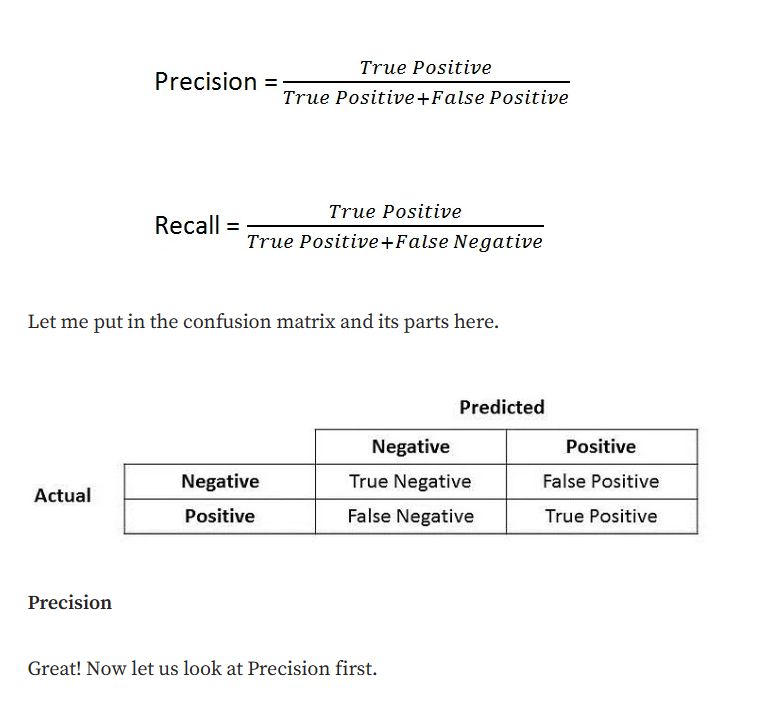
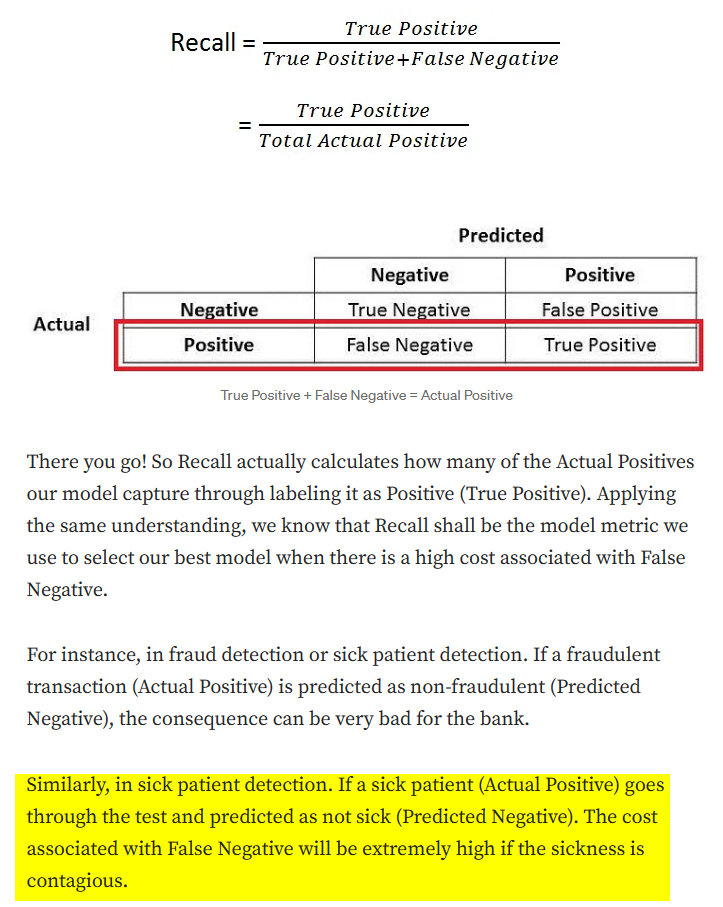
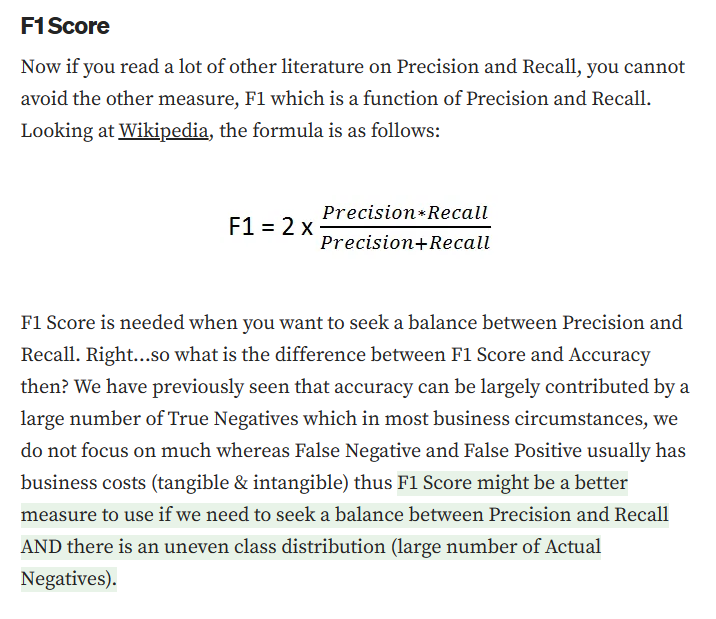
https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

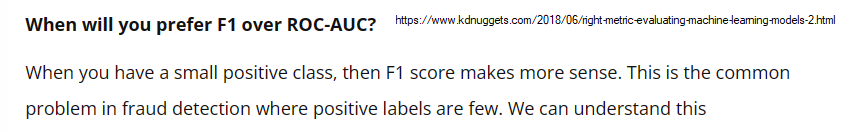

In [9]:
# Define the target variable and features
X = merged_df.drop("Diabetes_binary", axis=1)  # Features - all columns except Diabetes_binary
y = merged_df["Diabetes_binary"]  # Diabetes_binary is the target variable

# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

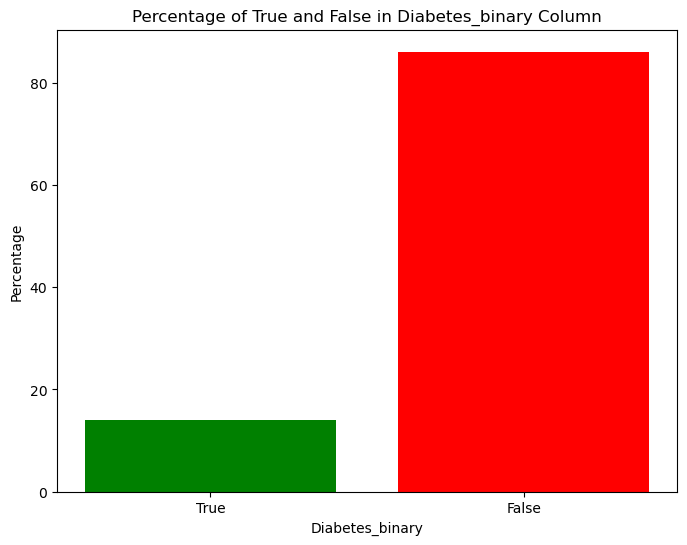

In [11]:
# Calculate the percentage of False values
false_percentage = (merged_df['Diabetes_binary'] == 0).mean() * 100

# Calculate the percentage of True values
true_percentage = 100 - false_percentage

# Create a bar plot to visualize the percentages
plt.figure(figsize=(8, 6))
plt.bar(['True', 'False'], [true_percentage, false_percentage], color=['green', 'red'])
plt.xlabel('Diabetes_binary')
plt.ylabel('Percentage')
plt.title('Percentage of True and False in Diabetes_binary Column')
plt.show()

In [11]:
# Run LogisticRegression model with NO scaling as logistic regression is not as sensitive to feature scaling 
#     as some other algorithms
# Define the target variable and features
# X = merged_df.drop("Diabetes_binary", axis=1)  # Features - all columns except Diabetes_binary
# y = merged_df["Diabetes_binary"]  # Diabetes_binary is the target variable

# Split the data into training and testing sets 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

# Instantiate the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=47)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Calculate performance measures
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)  
cm = confusion_matrix(y_test, y_pred)

# Print the results
print(f"Model: Logistic Regression Model")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Matthews Correlation Coefficient (MCC): {mcc}")
print(f"Confusion Matrix:\n{cm}")
print(f"Classification Report:\n{classification_report_str}")
print("\n")

Model: Logistic Regression Model
Accuracy: 0.8635091453800063
F1 Score: 0.24391309094879357
Precision: 0.5283822138126774
Recall: 0.15855216465578426
Matthews Correlation Coefficient (MCC): 0.23488347389085087
Confusion Matrix:
[[42694   997]
 [ 5928  1117]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.92     43691
           1       0.53      0.16      0.24      7045

    accuracy                           0.86     50736
   macro avg       0.70      0.57      0.58     50736
weighted avg       0.83      0.86      0.83     50736





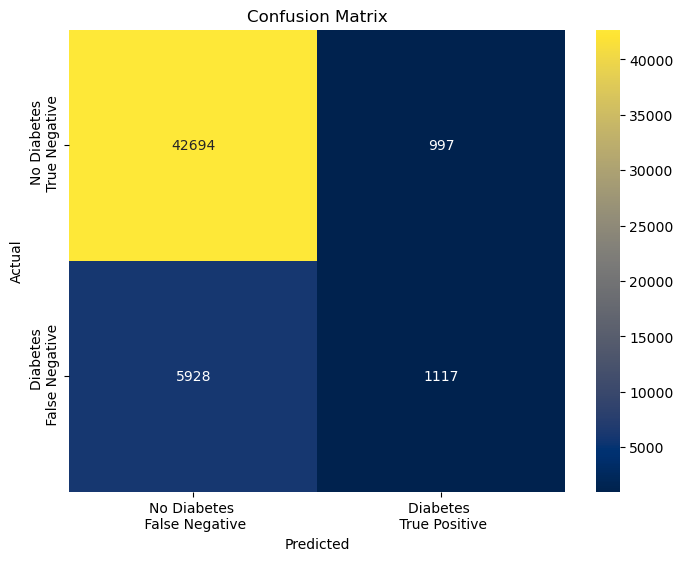

In [14]:
# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="cividis",
            xticklabels=["No Diabetes \n False Negative", "Diabetes \n True Positive"],
            yticklabels=["No Diabetes \n True Negative", "Diabetes \n False Negative"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

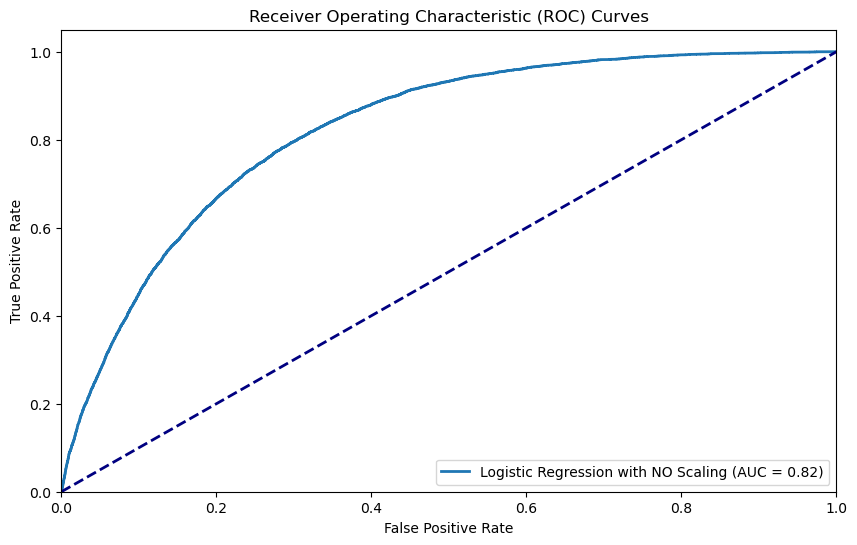

In [15]:
# Create the ROC and AUC graph
model_name = "Logistic Regression with NO Scaling"

# Predict probabilities for the positive class (class 1)
y_pred_prob = model.predict_proba(X_test)[:, 1]
    
# Calculate ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    
# Calculate AUC
roc_auc = auc(fpr, tpr)
    
# Plot ROC Curves for this model
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

In [16]:
# Save the unscaled data
X_train_unscaled = X_train
X_test_unscaled  = X_test
y_train_unscaled = y_train
y_test_unscaled  = y_test

In [11]:
# Now use the standard scaler to scale the non-binary data
# Import for standardization

# Instantiate 
scaler = StandardScaler()

# Fit the scaler to your training data
scaler.fit(X_train[['PhysHlth', 'GenHlth', 'MentHlth', 'BMI', 'Age', 'Education', 'Income']])

# Transform the training and testing data
X_train[['PhysHlth', 'GenHlth', 'MentHlth', 'BMI', 'Age', 'Education', 'Income']] = scaler.transform(X_train[['PhysHlth','GenHlth', 'MentHlth', 'BMI', 'Age', 'Education', 'Income']])
X_test[['PhysHlth', 'GenHlth', 'MentHlth', 'BMI', 'Age', 'Education', 'Income']] = scaler.transform(X_test[['PhysHlth', 'GenHlth', 'MentHlth', 'BMI', 'Age', 'Education', 'Income']])

In [30]:
#from sklearn.svm import SVC
#import xgboost as xgb
#import lightgbm as lgb
#import catboost as cat
#from catboost import CatBoostClassifier, Pool

In [18]:
# Define the list of models to process for comparison
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=47)),
    ('Random Forest', RandomForestClassifier(random_state=47)),
    ('XGBoost', xgb.XGBClassifier(random_state=47)),
    ('MLP', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=47))
]


# Create the list of pipelines for each model to be used the next step
pipelines = []
for model_name, model in models:
    pipelines.append((
        model_name,
        Pipeline([
            ('Model', model)  
        ])
    ))

In [19]:
# Calculate the performance measures and the elapsed run time of each model 
start = time.time()

for model_name, model_pipeline in pipelines:
    # Fit the model using the pipeline
    model_pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model_pipeline.predict(X_test)
    
    # Calculate performance measures
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)  
    cm = confusion_matrix(y_test, y_pred)

    # Print the results
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Matthews Correlation Coefficient (MCC): {mcc}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Classification Report:\n{classification_report_str}")
    print(f"Elapsed Run Time in Seconds: {time.time() - start:.2f}")
    print("-------------------------------------------------------")
    print("\n")

Model: Logistic Regression
Accuracy: 0.8635091453800063
F1 Score: 0.24391309094879357
Precision: 0.5283822138126774
Recall: 0.15855216465578426
Matthews Correlation Coefficient (MCC): 0.23488347389085087
Confusion Matrix:
[[42694   997]
 [ 5928  1117]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.92     43691
           1       0.53      0.16      0.24      7045

    accuracy                           0.86     50736
   macro avg       0.70      0.57      0.58     50736
weighted avg       0.83      0.86      0.83     50736

Elapsed Run Time in Seconds: 1.06
-------------------------------------------------------


Model: Random Forest
Accuracy: 0.859035004730369
F1 Score: 0.25062866722548194
Precision: 0.4785914365746298
Recall: 0.16976579134137687
Matthews Correlation Coefficient (MCC): 0.2236214790014274
Confusion Matrix:
[[42388  1303]
 [ 5849  1196]]
Classification Report:
              precision    recall  f1

Model: Logistic Regression
Recall: 0.15855216465578426
Specificity: 0.9771806550548168
Precision: 0.5283822138126774
-------------------------------------------------------


Model: Random Forest
Recall: 0.16976579134137687
Specificity: 0.9701769243093543
Precision: 0.4785914365746298
-------------------------------------------------------


Model: XGBoost
Recall: 0.17146912704045422
Specificity: 0.9771119910279005
Precision: 0.5471014492753623
-------------------------------------------------------


Model: MLP
Recall: 0.20482611781405252
Specificity: 0.9626696573665057
Precision: 0.4694209499024073
-------------------------------------------------------




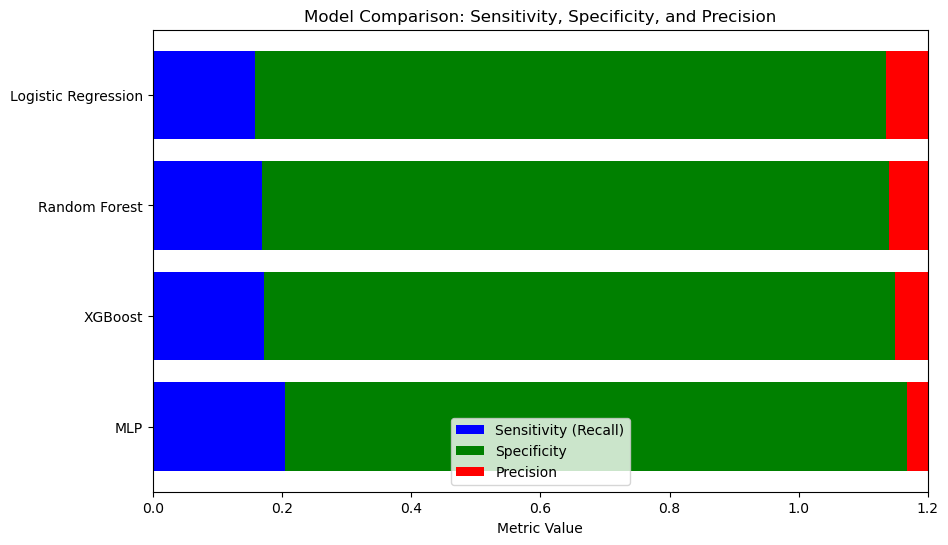

In [20]:
# Create empty lists to record metrics
model_names = []
sensitivities = []
specificities = []
precisions = []

# Evaluate each model in the pipeline
for model_name, model in pipelines:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Calculate Sensitivity (Recall)
    sensitivity = tp / (tp + fn)
    
    # Calculate Specificity
    specificity = tn / (tn + fp)
    
    # Calculate Precision
    precision = tp / (tp + fp)
    
    # Append results to lists
    model_names.append(model_name)
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    precisions.append(precision)
    
    # Print the results
    print(f"Model: {model_name}")
    print(f"Recall: {sensitivity}")
    print(f"Specificity: {specificity}")
    print(f"Precision: {precision}")
    print("-------------------------------------------------------")
    print("\n")

# Create a bar plot to compare evaluation metrics
plt.figure(figsize=(10, 6))
plt.barh(model_names, sensitivities, color='b', label='Sensitivity (Recall)')
plt.barh(model_names, specificities, left=sensitivities, color='g', label='Specificity')
plt.barh(model_names, precisions, left=[s + sp for s, sp in zip(sensitivities, specificities)], color='r', label='Precision')
plt.xlabel('Metric Value')
plt.title('Model Comparison: Sensitivity, Specificity, and Precision')
plt.legend()
plt.xlim(0, 1.2)  # Adjust the x-axis limit as needed
plt.gca().invert_yaxis()  # Invert the y-axis for better visualization
plt.show()


AUC for Logistic Regression, 0.82
AUC for Random Forest, 0.80
AUC for XGBoost, 0.83
AUC for MLP, 0.80


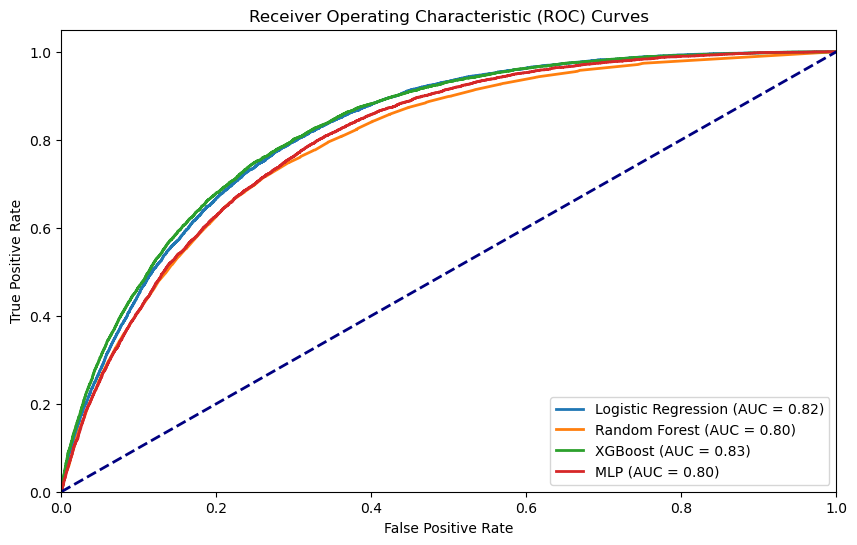

In [24]:
# Graph AUC and ROC for each model

# Create empty lists to store ROC values
roc_curves = []

# Create empty dictionary to store AUC values
auc_scores = {}

# Iterate through each model in the pipeline
for model_name, model in pipelines:
    model.fit(X_train, y_train)
    
    # Predict probabilities for the positive class (class 1)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    
    # Calculate AUC
    roc_auc = auc(fpr, tpr)
    
    # Append ROC Curve data and AUC data
    roc_curves.append((model_name, fpr, tpr))
    auc_scores[model_name] = roc_auc

# Plot ROC Curves for each model
plt.figure(figsize=(10, 6))
for model_name, fpr, tpr in roc_curves:
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {auc_scores[model_name]:.2f})')
    print(f'AUC for {model_name}, {auc_scores[model_name]:.2f}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

In [21]:
model = LogisticRegression(max_iter=1000, random_state=47)

# Fit the model to the training data
model.fit(X_train, y_train)

feature_names = X_train.columns  
coefficients = model.coef_[0]
# Pair feature names with their coefficients
feature_coefficients = list(zip(feature_names, coefficients))

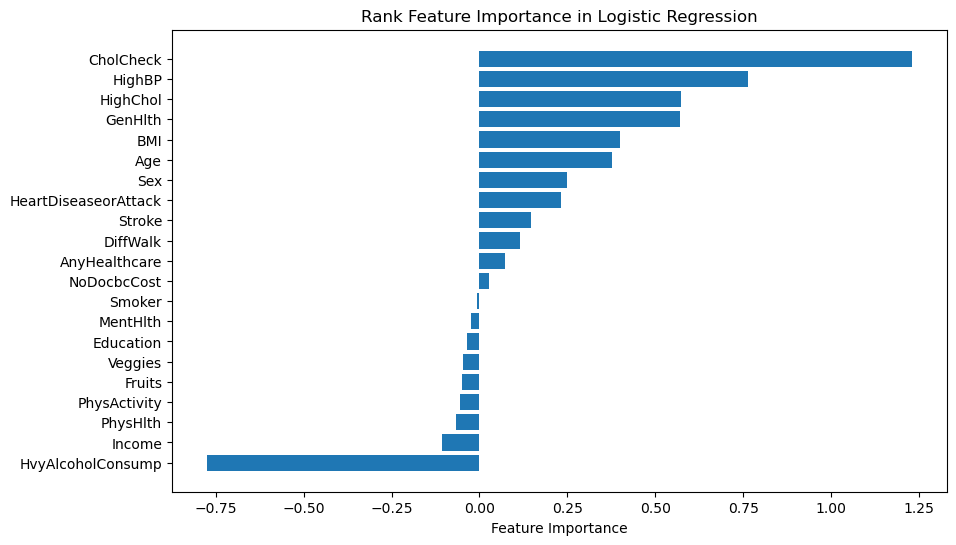

In [22]:
# Feature importance for logistic regression model
# Sort feature importances in descending order
feature_coefficients.sort(key=lambda x: x[1], reverse=True)

# Get feature names and importance
sorted_feature_names, sorted_importance_scores = zip(*feature_coefficients)

# Use a bar plot to visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importance_scores)
plt.xlabel('Feature Importance')
plt.title('Rank Feature Importance in Logistic Regression')
plt.gca().invert_yaxis()  
plt.show()

In [55]:
# XGBoost Model
model = xgb.XGBClassifier(random_state=47)

# Fit the model to the training data
model.fit(X_train, y_train)
    
# XGBoost model
feature_names = X_train.columns 
feature_importance = model.feature_importances_

# Pair feature names with importance scores
feature_importance_scores = list(zip(feature_names, feature_importance))

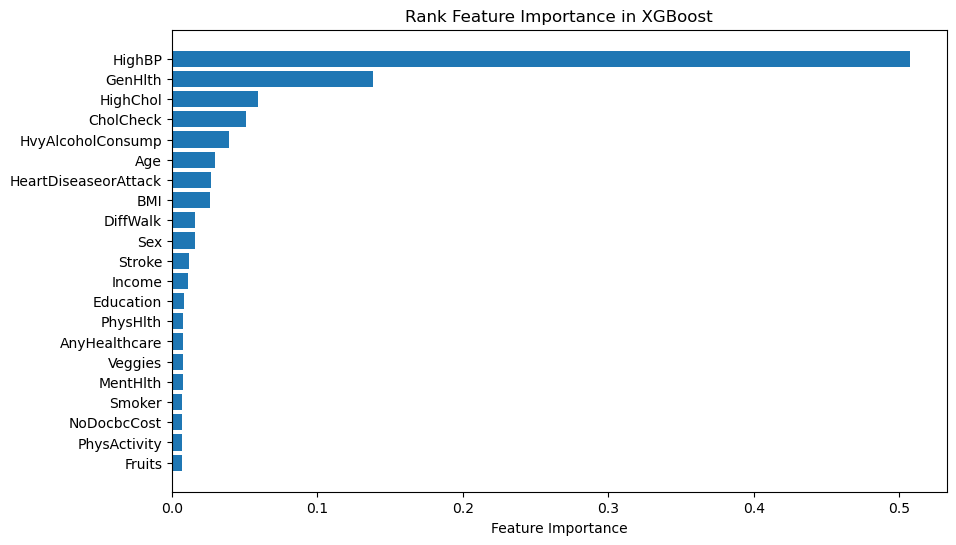

In [56]:
# Sort feature importances in descending order
feature_importance_scores.sort(key=lambda x: x[1], reverse=True)

# Extract feature names and importance scores
sorted_feature_names, sorted_importance_scores = zip(*feature_importance_scores)

# Use a bar plot to visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importance_scores)
plt.xlabel('Feature Importance')
plt.title('Rank Feature Importance in XGBoost')
plt.gca().invert_yaxis()  
plt.show()

In [58]:
('Random Forest', RandomForestClassifier(random_state=47)),

# Random Forest model
model = RandomForestClassifier(random_state=47)

# Fit the model to the training data
model.fit(X_train, y_train)

feature_importances = model.feature_importances_

# Pair feature importances with feature names
feature_names = X_train.columns
feature_importance_scores = list(zip(feature_names, feature_importances))

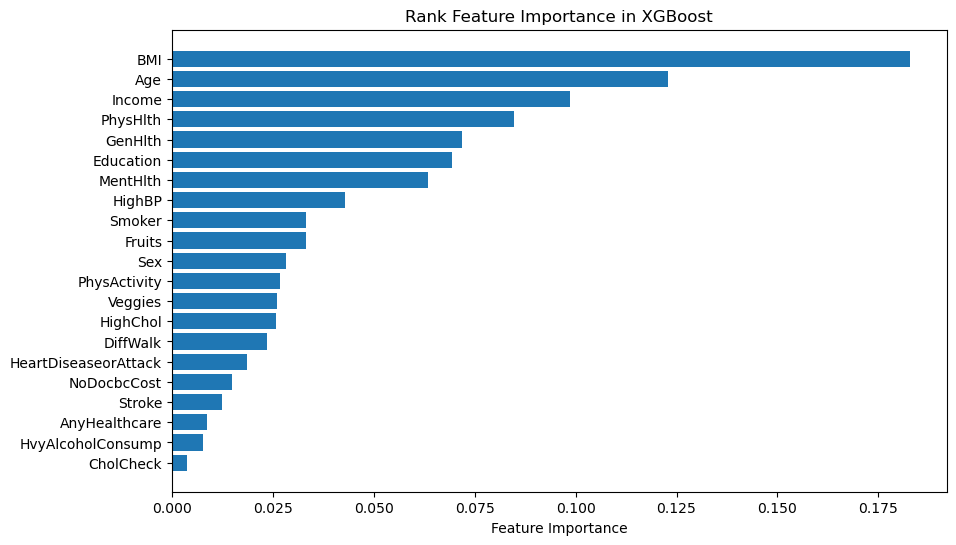

In [59]:
# Sort feature importances in descending order
feature_importance_scores.sort(key=lambda x: x[1], reverse=True)

# Get feature names and importance
sorted_feature_names, sorted_importance_scores = zip(*feature_importance_scores)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importance_scores)
plt.xlabel('Feature Importance')
plt.title('Rank Feature Importance in XGBoost')
plt.gca().invert_yaxis()  
plt.show()

In [12]:
# Try Microsoft LightGBM (Light Gradient Boosting Machine) 
# LightGBM uses cases:
#      Large Datasets / High-Dimensional Data Sets / Classification and Regression / Imbalanced Datasets /Speed and Efficiency
#      Parallel and Distributed Computing / Categorical Features / Optimization

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'scale_pos_weight': (len(y_train) - np.sum(y_train)) / np.sum(y_train),  # Custom weight for imbalance
}

model = lgb.LGBMClassifier(**params)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

## Start - XGBoost Hypereparameter Tuning

In [12]:
start = time.time()

# Define the hyperparameter search space
param_dist = {
    'n_estimators': stats.randint(100, 1000),  # Random integer between 100 and 1000
    'max_depth': stats.randint(3, 10),        # Random integer between 3 and 10
    'learning_rate': stats.uniform(0.01, 0.3),  # Random float between 0.01 and 0.3
    'subsample': stats.uniform(0.6, 0.4),       # Random float between 0.6 and 1.0
    'colsample_bytree': stats.uniform(0.6, 0.4),  # Random float between 0.6 and 1.0
    'gamma': stats.uniform(0, 2),               # Random float between 0 and 2
    'reg_alpha': stats.uniform(0, 0.2),         # Random float between 0 and 0.2
    'reg_lambda': stats.uniform(0, 0.2)         # Random float between 0 and 0.2
}

# Create the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=xgb_classifier, param_distributions=param_dist, 
                                   n_iter=100, scoring='f1', cv=5, verbose=2, n_jobs=-1)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding F1 score
print("Best Hyperparameters:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)

# Get the best XGBoost classifier
best_xgb_classifier = random_search.best_estimator_

# Fit the best model to the training data
best_xgb_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_xgb_classifier.predict(X_test)

print(f"Elapsed Run Time in Seconds: {time.time() - start:.2f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters: {'colsample_bytree': 0.882941588414334, 'gamma': 0.11680254801283141, 'learning_rate': 0.24279795017565242, 'max_depth': 9, 'n_estimators': 507, 'reg_alpha': 0.12834665295748382, 'reg_lambda': 0.06867863400380705, 'subsample': 0.6521141789156024}
Best F1 Score: 0.3060670041936083
Elapsed Run Time in Seconds: 1758.35


In [13]:
# Best hyperparameters obtained from RandomizedSearchCV
best_params = {
    'colsample_bytree': 0.882941588414334,
    'gamma': 0.11680254801283141,
    'learning_rate': 0.24279795017565242,
    'max_depth': 9,
    'n_estimators': 507,
    'reg_alpha': 0.12834665295748382,
    'reg_lambda': 0.06867863400380705,
    'subsample': 0.6521141789156024
}

# Create an instance of the XGBoost classifier with the best hyperparameters
tuned_xgb_classifier = xgb.XGBClassifier(
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    subsample=best_params['subsample']
)

# Fit the model to your training data
tuned_xgb_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = tuned_xgb_classifier.predict(X_test)

In [17]:
# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Calculate performance measures
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)  
cm = confusion_matrix(y_test, y_pred)

# Print the results
print(f"Model: Tuned XGBoost Model")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Matthews Correlation Coefficient (MCC): {mcc}")
print(f"Confusion Matrix:\n{cm}")
print(f"Classification Report:\n{classification_report_str}")
print("\n")

Model: Tuned XGBoost Model
Accuracy: 0.8473864711447493
F1 Score: 0.3047499326569094
Precision: 0.41471163245356796
Recall: 0.24088005677785665
Matthews Correlation Coefficient (MCC): 0.23628243997477713
Confusion Matrix:
[[41296  2395]
 [ 5348  1697]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.91     43691
           1       0.41      0.24      0.30      7045

    accuracy                           0.85     50736
   macro avg       0.65      0.59      0.61     50736
weighted avg       0.82      0.85      0.83     50736





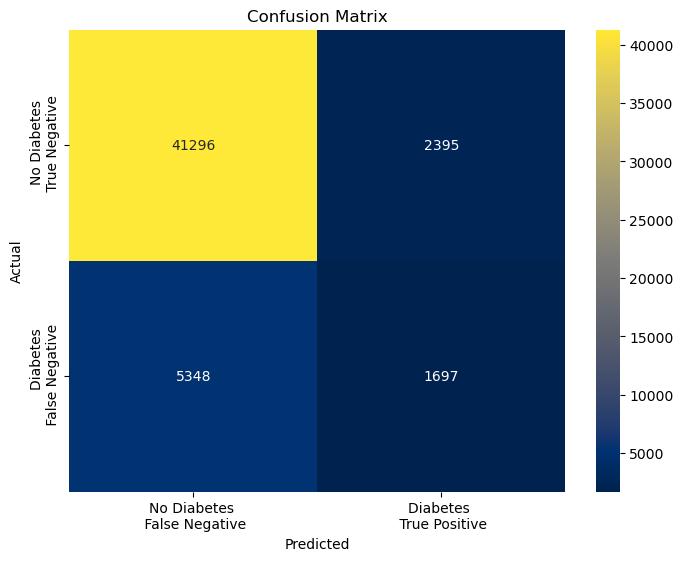

In [15]:
# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="cividis",
            xticklabels=["No Diabetes \n False Negative", "Diabetes \n True Positive"],
            yticklabels=["No Diabetes \n True Negative", "Diabetes \n False Negative"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

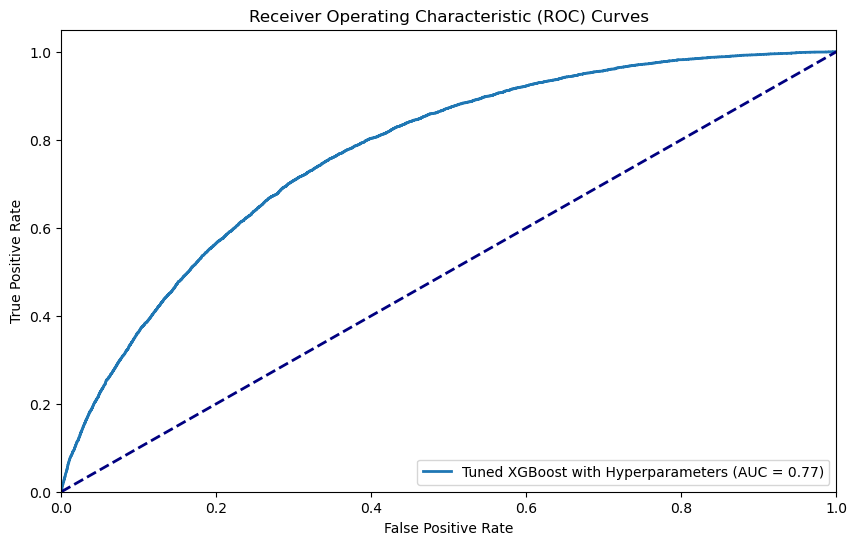

In [16]:
# Create the ROC and AUC graph
model_name = "Tuned XGBoost with Hyperparameters"

# Predict probabilities for the positive class (class 1)
y_pred_prob = tuned_xgb_classifier.predict_proba(X_test)[:, 1]
    
# Calculate ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    
# Calculate AUC
roc_auc = auc(fpr, tpr)
    
# Plot ROC Curves for this model
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

## End - XGBoost Hypereparameter Tuning

**<font color='teal' size='4'> So the logistic regression model gives us the least number of false positives. Now we will try and tune the hyperparameters and see if we can improve the model. </font>** 

In [12]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid and regularization penalty ('l1' or 'l2')
param_grid = {
    'penalty': ['l1', 'l2'], 
    'C': [0.001, 0.01, 0.1, 1.0, 10.0]  
}

# Create the logistic regression model
logistic_regression = LogisticRegression(max_iter=1000)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, 
                           scoring='f1', cv=5, verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding F1 score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Get the best logistic regression model
best_logistic_regression_model = grid_search.best_estimator_

# Fit the best model to the training data
best_logistic_regression_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_logistic_regression_model.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


D:\Users\Ron\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Users\Ron\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Users\Ron\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Users\Ron\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = _check_so

Best Hyperparameters: {'C': 10.0, 'penalty': 'l2'}
Best F1 Score: 0.24204805367942175


In [13]:
# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# Calculate performance measures
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)  
cm = confusion_matrix(y_test, y_pred)

# Print the results
print(f"Model: Logistic Regression Model")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Matthews Correlation Coefficient (MCC): {mcc}")
print(f"Confusion Matrix:\n{cm}")
print(f"Classification Report:\n{classification_report_str}")
print("\n")

Model: Logistic Regression Model
Accuracy: 0.8634697256385998
F1 Score: 0.24319895116355292
Precision: 0.527988614800759
Recall: 0.1579843860894251
Matthews Correlation Coefficient (MCC): 0.23429845317917763
Confusion Matrix:
[[42696   995]
 [ 5932  1113]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.92     43691
           1       0.53      0.16      0.24      7045

    accuracy                           0.86     50736
   macro avg       0.70      0.57      0.58     50736
weighted avg       0.83      0.86      0.83     50736





In [14]:
feature_names = X_train.columns  
coefficients = best_logistic_regression_model.coef_[0]
# Pair feature names with their coefficients
feature_coefficients = list(zip(feature_names, coefficients))

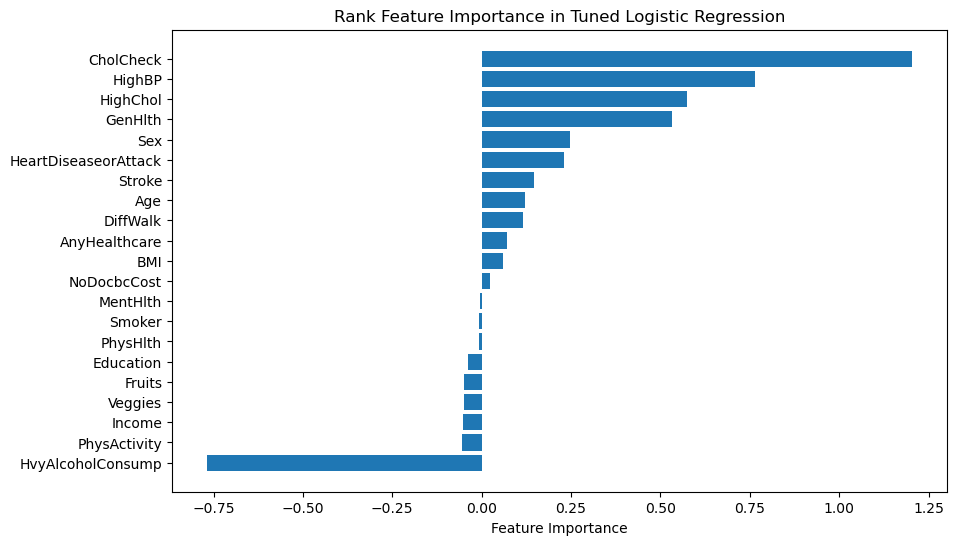

In [15]:
# Feature importance for logistic regression model
# Sort feature importances in descending order
feature_coefficients.sort(key=lambda x: x[1], reverse=True)

# Get feature names and importance
sorted_feature_names, sorted_importance_scores = zip(*feature_coefficients)

# Use a bar plot to visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importance_scores)
plt.xlabel('Feature Importance')
plt.title('Rank Feature Importance in Tuned Logistic Regression')
plt.gca().invert_yaxis()  
plt.show()

In [43]:
# Best Hyperparameters: {'C': 10.0, 'penalty': 'l2'}

# Define class weights
class_weights = {0: 1.0, 1: 5.0}

# Create the logistic regression model with the best hyperparameters
tuned_logistic_regression_model = LogisticRegression(class_weight=class_weights, C=10.0, penalty='l2', max_iter=1000)  # Set max_iter to a reasonable value

# Fit the logistic regression model to the training data
tuned_logistic_regression_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = tuned_logistic_regression_model.predict(X_test)
# y_pred_adjusted = best_logistic_regression_model.predict(X_test)

# Predict probabilities for the positive class (class 1)
y_pred_prob = tuned_logistic_regression_model.predict_proba(X_test)[:, 1]

# Try a different threshold 
threshold = 0.53

# Adjust predictions based on the threshold
y_pred_adjusted = (y_pred_prob >= threshold).astype(int)

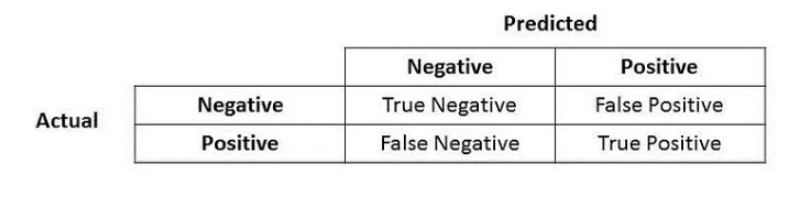

In [44]:
# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred_adjusted)
confusion = confusion_matrix(y_test, y_pred_adjusted)
classification_report_str = classification_report(y_test, y_pred_adjusted)

# Calculate performance measures
accuracy = accuracy_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)
mcc = matthews_corrcoef(y_test, y_pred_adjusted)  
cm = confusion_matrix(y_test, y_pred_adjusted)

# Print the results
print(f"Model: Logistic Regression Model")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Matthews Correlation Coefficient (MCC): {mcc}")
print(f"Confusion Matrix:\n{cm}")
print(f"Classification Report:\n{classification_report_str}")
print("\n")

Model: Logistic Regression Model
Accuracy: 0.7771010722169662
F1 Score: 0.45861458183733067
Precision: 0.3459982663969951
Recall: 0.6799148332150461
Matthews Correlation Coefficient (MCC): 0.3669552204185077
Confusion Matrix:
[[34637  9054]
 [ 2255  4790]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.79      0.86     43691
           1       0.35      0.68      0.46      7045

    accuracy                           0.78     50736
   macro avg       0.64      0.74      0.66     50736
weighted avg       0.86      0.78      0.80     50736





<font color='teal' size='4'> There are other tuning parameters we could try such as "Feature Engineering" or "Ensemble Methods" but using the Best Hyperparameters: {'C': 10.0, 'penalty': 'l2'} gives us the fewest false positives. We want to reduce false positives in order to prevent the patient undergoing additonal medical testing and cost. </font>

 ## End Modeling
**<font color='teal'> End Modeling </font>**

In [26]:
from sklearn.model_selection import GridSearchCV

# Set up hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],      # Number of boosting rounds
    'max_depth': [3, 4, 5],               # Max depth of trees
    'learning_rate': [0.01, 0.1, 0.2],    # Learning rate
    'subsample': [0.8, 0.9, 1.0],         # Fraction of samples used for training
    'colsample_bytree': [0.8, 0.9, 1.0],  # Fraction of features used for training
    'gamma': [0, 1, 2],                   # Minimum loss reduction required to make a further partition on a leaf node
    'reg_alpha': [0, 0.1, 0.2],           # L1 regularization term on weights
    'reg_lambda': [0, 0.1, 0.2]           # L2 regularization term on weights
}

# Instantiate the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, 
                           scoring='f1', cv=5, verbose=2, n_jobs=-1)

# Fit grid_search to the data
grid_search.fit(X_train, y_train)

# Print what grid_search found as the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Get the best XGBoost classifier
tuned_xgb_classifier = grid_search.best_estimator_

# Fit the best model to the training data
tuned_xgb_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = tuned_xgb_classifier.predict(X_test)

Fitting 5 folds for each of 6561 candidates, totalling 32805 fits


PicklingError: Could not pickle the task to send it to the workers.

In [42]:
# Feature importance for all models except MLP
for model_name, model in pipelines:
    
    model.fit(X_train, y_train)
    print(model_name, model)
    
    if model_name == 'Logistic Regression':
        feature_names = X_train.columns  
        coefficients = model.coef_[0]
        # Pair feature names with their coefficients
        feature_coefficients = list(zip(feature_names, coefficients))
    elif model_name == 'Random Forest':
        feature_importances = model.feature_importances_
        # Pair feature importances with feature names
        feature_names = X_train.columns
        feature_importance_scores = list(zip(feature_names, feature_importances))
    elif model_name == 'XGBoost':
        feature_names = X_train.columns  
        feature_importance = model.feature_importances_
        # Pair feature names with their importance scores
        feature_importance_scores = list(zip(feature_names, feature_importance)) 

Logistic Regression Pipeline(steps=[('Model', LogisticRegression(max_iter=1000, random_state=47))])


AttributeError: 'Pipeline' object has no attribute 'coef_'

In [ ]:
y_pred = knn.predict(X_test)
pl = confusion_matrix(y_test,y_pred)


# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(pl, annot=True, fmt="d", cmap="cividis",
            xticklabels=["No Diabetes", "Diabetes"],
            yticklabels=["No Diabetes", "Diabetes"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()